In [29]:
import numpy as np
import cv2
from pydub import AudioSegment
from pydub.utils import make_chunks
from scipy.signal import butter, filtfilt
from glob import glob
import matplotlib.pyplot as plt
import math

### 動画準備

In [30]:
# 動画ファイルの読み込み
input_video_path = 'input_video.mp4'
cap = cv2.VideoCapture(input_video_path)

# 動画のプロパティを取得
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


# 出力ファイルの設定
output_video_path = 'output.avi'
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

CHUNK = round(1000/fps)

print(CHUNK)

33


### wavファイルをmp3に変換

In [31]:
audio1 = AudioSegment.from_wav("./スコープコーダデータ/t_output.wav")
audio2 = AudioSegment.from_wav("./スコープコーダデータ/b_output.wav")
audio3 = AudioSegment.from_wav("./スコープコーダデータ/r_output.wav")
audio4 = AudioSegment.from_wav("./スコープコーダデータ/l_output.wav")

audio1.export("./スコープコーダデータ/t_output.mp3", format="mp3")
audio2.export("./スコープコーダデータ/b_output.mp3", format="mp3")
audio3.export("./スコープコーダデータ/r_output.mp3", format="mp3")
audio4.export("./スコープコーダデータ/l_output.mp3", format="mp3")

print("done")

done


### 音声データの読み込みと分割

In [32]:
# サンプリングレートとチャンクサイズの設定
RATE = 44100

mp3_paths = glob("./スコープコーダデータ/*.mp3")
for p in mp3_paths:
    print(p)

def makeChunks(file_paths, chunk):
    # data = [AudioSegment.from_file(file_path) for file_path in file_paths]
    data = [make_chunks(AudioSegment.from_file(file_path), chunk) for file_path in file_paths]
    return data

chunks = makeChunks(mp3_paths, CHUNK)
b_chunk, l_chunk, r_chunk, t_chunk = chunks

print(r_chunk)

for idx, file_chunks in enumerate(chunks):
    print(f"File {idx} has {len(file_chunks)} chunks")

    
AudioSegment.from_file("./スコープコーダデータ/r_output.mp3")

./スコープコーダデータ\b_output.mp3
./スコープコーダデータ\l_output.mp3
./スコープコーダデータ\r_output.mp3
./スコープコーダデータ\t_output.mp3
[<pydub.audio_segment.AudioSegment object at 0x00000286D4DC8EB0>, <pydub.audio_segment.AudioSegment object at 0x000002868609EC40>, <pydub.audio_segment.AudioSegment object at 0x000002868609EAC0>, <pydub.audio_segment.AudioSegment object at 0x000002868609EBE0>, <pydub.audio_segment.AudioSegment object at 0x000002868609EC70>, <pydub.audio_segment.AudioSegment object at 0x000002868609EEE0>, <pydub.audio_segment.AudioSegment object at 0x000002868609EC10>, <pydub.audio_segment.AudioSegment object at 0x000002868609ECA0>, <pydub.audio_segment.AudioSegment object at 0x000002868609ED30>, <pydub.audio_segment.AudioSegment object at 0x000002868609EB20>, <pydub.audio_segment.AudioSegment object at 0x000002868609EAF0>, <pydub.audio_segment.AudioSegment object at 0x000002868609ED90>, <pydub.audio_segment.AudioSegment object at 0x000002868609EDC0>, <pydub.audio_segment.AudioSegment object at 0x0000

### 関数定義

In [33]:
def get_audio_data(chunk):
    """
    音声データの取得\n
    parameters 
    ---
    stream _Stream : camera frame object
    """
    audio_data = np.array(chunk.get_array_of_samples(), dtype=np.int16)
    return audio_data

def normalize(signal):
    """信号のスケーリング（正規化）\n
    prameters
    ---
    signal: audio data
    """
    signal_min = np.min(signal)
    signal_max = np.max(signal)
    normalized_signal = (signal - signal_min) / (signal_max - signal_min)
    signal_min = np.min(signal)
    signal_max = np.max(signal)
    return normalized_signal, signal_min, signal_max

def denormalize(normalized_signal, signal_min, signal_max):
    original_signal = normalized_signal * (signal_max - signal_min) + signal_min
    return original_signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # ナイキスト周波数
    low = lowcut / nyq  # 正規化された下限カットオフ周波数
    high = highcut / nyq  # 正規化された上限カットオフ周波数
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def moving_average(signal, window_size=5):
    """ノイズ除去（移動平均フィルタを使用）"""
    return np.convolve(signal, np.ones(window_size)/window_size, mode="valid")

def fft_correlation(x, y):
    N = len(x) + len(y) - 1
    X = np.fft.fft(x, N)
    Y = np.fft.fft(y, N)
    Y_conj = np.conj(Y)
    product = X * Y_conj
    correlation = np.fft.ifft(product).real / N
    return correlation

def time_domain_correlation(x, y):
    correlation = np.zeros(len(x) + len(y) - 1)
    for lag in range(-len(y) + 1, len(x)):
        if lag < 0:
            correlation[lag + len(y) - 1] = np.sum(x[:lag] * y[-lag:])
        else:
            correlation[lag + len(y) - 1] = np.sum(x[lag:] * y[:len(y) - lag])
    return correlation

def numpy_to_audiosegment(data, sample_rate):
    audio = AudioSegment(
        data.tobytes(), 
        frame_rate=sample_rate,
        sample_width=data.dtype.itemsize, 
        channels=1
    )
    return audio

# フィルタ処理されたデータを音声ファイルに保存する関数
def save_filtered_audio(data, sample_rate, file_path):
    data = normalize(data)
    audio_segment = numpy_to_audiosegment(data, sample_rate)
    audio_segment.export(file_path, format="wav")

def determine_sound_direction(data1, data2, _type="X"):
    """音源の方向を特定\n
    prameters
    ---
    data1 audio1 : audio data
    data2 audio2 : audio data
    """
    # 移動平均化(ノイズ処理)
    data1 = moving_average(data1)
    data2 = moving_average(data2)
    
    # バンドパスフィルタ
    lowcut = 20
    highcut = 20000
    data1_filtered = bandpass_filter(data1, lowcut, highcut, RATE)
    data2_filtered = bandpass_filter(data2, lowcut, highcut, RATE)

    # 正規化
    data1_normalized, data1_min, data1_max = normalize(data1_filtered)
    data2_normalized, data2_min, data2_max = normalize(data2_filtered)

    # 2つの信号相関を計算
    correlation = time_domain_correlation(data2_normalized, data1_normalized)
    delay = np.argmax(correlation) - (len(data2_normalized) - 1)

    # 音源がどちらにあるかを判定
    if _type == "X":
        if delay > 0:
            delay_text = "Left" 
        elif delay < 0: 
            delay_text = "Right"
        else: 
            delay_text = "Center"
    else :
        if delay > 0: 
            delay_text = "Bottom"
        elif delay < 0: 
            delay_text = "Top"
        else: 
            delay_text = "Center"
    return (delay_text, delay), (data1_normalized, data1_normalized), (data1_max, data1_min, data2_max, data2_min)

def calculate_decibels(data):
    """デシベルを計算\n
    Parameters
    ---
    audio_data numpy array : audio data
    """
    # ノイズ検出
    std = np.std(data)
    threshold = 300
    data = np.where(std < threshold, 0, data)
    squaressum = 0
    for d in data:
        squaressum = squaressum + (d**2)
    
    meansquare = abs(squaressum) / (len(data) / 2)
    # 二乗平均平方を取得  (入出力信号レベル)
    rms = math.sqrt(meansquare)
    # RMSが0の場合のエラー処理
    if rms == 0:
        decibel = -np.inf
    else:
        decibel = 20 * math.log10(rms)
    return decibel

def calculate_position(
        frame, 
        direction_x, direction_y, 
        delay_x, delay_y, 
        mic_distance=0.05
    ):
    """音源の位置を計算\n
    parameters
    ---
    frame ndarray : camera frame
    direction str : sound direction
    delay int : sound delay
    mic_distance : float : distance between microphones (meters)
    """
    sound_speed = 343.2     # 音の速度 (m/s)
    delay_x_time = delay_x / RATE   # 遅延時間 (秒)
    distance_diff_x = delay_x_time * sound_speed    # 距離差 (メートル)
    delay_y_time = delay_y / RATE   # 遅延時間 (秒)
    distance_diff_y = delay_y_time * sound_speed    # 距離差 (メートル)
    
    # 音源の位置を推定 (簡略化)
    x = frame.shape[1] // 2
    y = frame.shape[0] // 2

    if direction_x == "Left":
        x += int((distance_diff_x / mic_distance) * -x)
    elif direction_x == "Right":
        x += int((distance_diff_x / mic_distance) * -x)
    
    if direction_y == "Bottom":
        y += int((distance_diff_y / mic_distance) * -y)
    elif direction_y == "Top":
        y += int((distance_diff_y / mic_distance) * -y)

    # 描画位置がフレーム内に収まるように調整
    x = max(0, min(x, frame.shape[1] - 1))
    y = max(0, min(y, frame.shape[0] - 1))
    return (x, y)

def get_color_and_radius(decibels):
    """
    デシベルの値に基づいて色と半径を決定する
    """
    if 20 < decibels < 50:
        color = (0, 255, 0, 128)  # 緑
        radius = 50
    elif 50 <= decibels < 90:
        color = (0, 255, 255, 128)  # 黄
        radius = 50
    elif 90 <= decibels:
        color = (0, 0, 255, 128)  # 赤
        radius = 50
    else :
        color = (0, 0, 0, 128)
        radius = 0
    return color, radius

def draw_transparent_circle(frame, position, radius, color):
    """
    透明度を持つ円を描画する
    """
    if radius == 0 or color[3] == 0:
        return
    
    overlay = frame.copy()
    cv2.circle(overlay, position, radius, color[:3], -1)  # color[:3] はBGR成分を取り出す

    alpha = color[3] / 255.0
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)


### 撮影 

In [34]:
decibels_list = []
frame_counter = 0
try:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if frame_counter >= len(r_chunk) or frame_counter >= len(b_chunk) or frame_counter >= len(t_chunk) or frame_counter >= len(l_chunk):
            break
        
        # read data
        audio_data_right = get_audio_data(t_chunk[frame_counter])
        audio_data_bottom = get_audio_data(r_chunk[frame_counter])
        audio_data_left = get_audio_data(b_chunk[frame_counter])
        audio_data_top = get_audio_data(l_chunk[frame_counter])
        
        # get sound direction
        delayInfo_x, audios_data_x, maxTOmin_x = determine_sound_direction(audio_data_right, audio_data_left, "X")
        direction_x, delay_x = delayInfo_x  #音源の方向(テキストと数値) 
        audio_r, audio_l = audios_data_x         #フィルタを通したデータ
        data_r_max, data_r_min, data_l_max, data_l_min = maxTOmin_x   #元データのmin and max

        delayInfo_y, audios_data_y, maxTOmin_y = determine_sound_direction(audio_data_top, audio_data_bottom, "Y")
        direction_y, delay_y = delayInfo_y  #音源の方向(テキストと数値) 
        audio_t, audio_b = audios_data_y         #フィルタを通したデータ
        data_t_max, data_t_min, data_b_max, data_b_min = maxTOmin_y   #元データのmin and max

        # denormalize
        denormalize_r = denormalize(audio_r, data_r_max, data_r_min)
        denormalize_l = denormalize(audio_l, data_l_max, data_l_min)
        denormalize_t = denormalize(audio_t, data_t_max, data_t_min)
        denormalize_b = denormalize(audio_b, data_b_max, data_b_min)

        # convertion of decibels
        decibels_bottom = calculate_decibels(denormalize_b)
        decibels_top = calculate_decibels(denormalize_t)
        decibels_right = calculate_decibels(denormalize_r)
        decibels_left = calculate_decibels(denormalize_l)

        print(direction_x, delay_x, direction_y, delay_y)
        print("bottom",decibels_bottom, "bottom",decibels_top, decibels_right, decibels_left)

        if direction_y == "Bottom":
            decibels_y = decibels_bottom
        elif direction_y == "Top":
            decibels_y = decibels_top
        else:
            decibels_y = (decibels_bottom + decibels_top) / 2
        
        if direction_x == "Right":
            decibels_x = decibels_right
        elif direction_x == "left":
            decibels_x = decibels_left
        else:
            decibels_x = (decibels_left + decibels_right) / 2
        
        position = calculate_position(frame, direction_x, direction_y, delay_x, delay_y)

        decibels = max([decibels_x, decibels_y])
        decibels_list.append(decibels)
        
        # デシベルに基づいて色と半径を決定
        color, radius = get_color_and_radius(decibels)
        
        # 透明度を持つ円を描画
        draw_transparent_circle(frame, position, radius, color)
        out.write(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        frame_counter += 1
except KeyboardInterrupt:
    print("終了します")

finally:
    cap.release()
    out.release()
    cv2.destroyAllWindows()

Right -3 Center 0
bottom 66.89191512851578 bottom 70.15186039109099 71.8408665846245 69.24479377816989
Right -3 Center 0
bottom 65.73824488060994 bottom 68.21889673652211 68.86806562152358 66.72929357014608
Right -3 Center 0
bottom 64.27890132333853 bottom 67.16872377096448 66.9661096315532 67.03603856693219
Right -3 Center 0
bottom 66.3642196440991 bottom 68.59783097996103 71.55936451792974 69.30308951010463
Right -3 Center 0
bottom 62.21403462173778 bottom 65.90650170164078 68.84457721518746 65.85488128842798
Right -3 Center 0
bottom 63.226503326525304 bottom 66.98209270853002 69.51822679552905 67.56486764473634
Right -3 Center 0
bottom 64.77831670132741 bottom 68.36116676418973 71.4406068924376 68.9779066713448
Right -3 Center 0
bottom 64.20020185680261 bottom 68.24545874196713 70.46737589092184 65.73973845177584
Right -3 Center 0
bottom 68.54400674360735 bottom 70.1716860638662 71.71647473719942 69.00391689521078
Right -3 Center 0
bottom 69.1446140882501 bottom 68.67647431752987 70

## 音声データ結合

In [35]:
import moviepy.editor as mp

clip_output = mp.VideoFileClip('output.avi').subclip()
clip_output.write_videofile('results.mp4', audio="./スコープコーダデータ/r_output.mp3")

Moviepy - Building video results.mp4.
Moviepy - Writing video results.mp4



Moviepy - Done !
Moviepy - video ready results.mp4


### データ確認

In [36]:
def show(datas, title):
    plt.figure(figsize=(20, 4))
    for data in datas:
        plt.plot(range(len(data)), data, alpha=0.5)
    plt.title(title)
    plt.show()

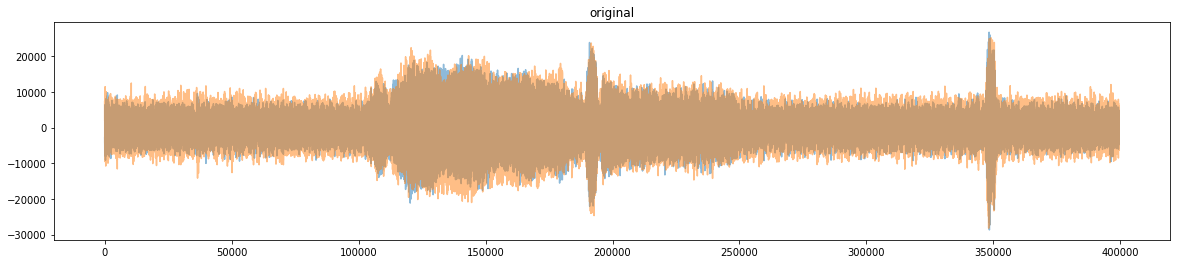

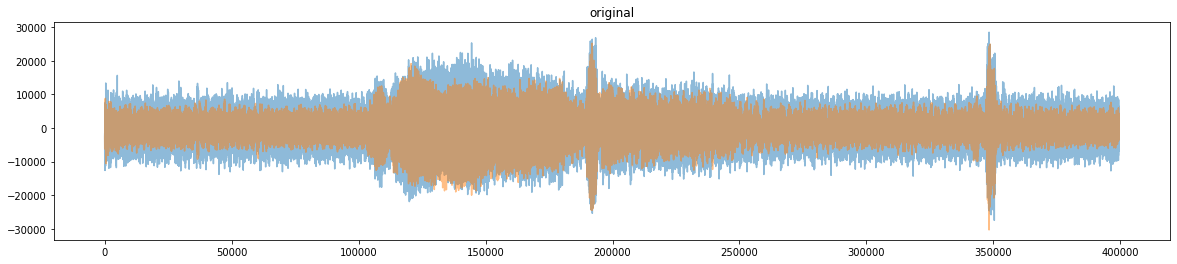

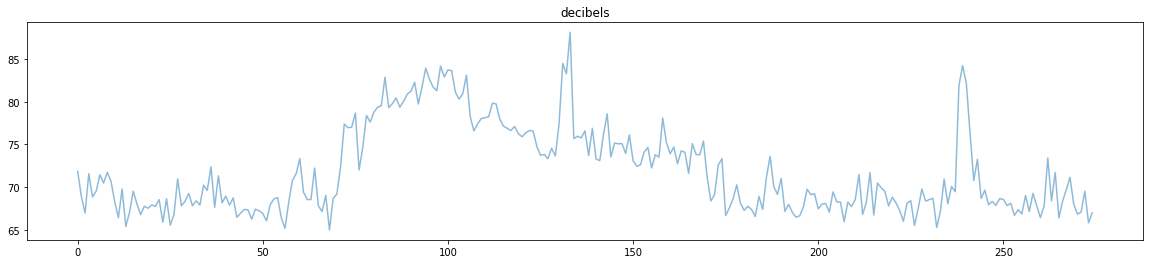

In [37]:
b = AudioSegment.from_file("./スコープコーダデータ/b_output.mp3")
r = AudioSegment.from_file("./スコープコーダデータ/r_output.mp3")
l = AudioSegment.from_file("./スコープコーダデータ/l_output.mp3")
t = AudioSegment.from_file("./スコープコーダデータ/t_output.mp3")

b = get_audio_data(b)
r = get_audio_data(r)
l = get_audio_data(l)
t = get_audio_data(t)
show([r, b], "original")
show([l, t], "original")

# l_data = moving_average(l, 5)
# r_data = moving_average(r, 5)
# b_data = moving_average(b, 5)
# t_data = moving_average(t, 5)
# show([l_data, r_data, b_data], "move_avg")

# b_data = normalize(b)
# r_data = normalize(r)
# l_data = normalize(l)
# t_data = normalize(t)
# show([l_data, r_data], "normalize")

# l_data = bandpass_filter(l_data, 20, 20000, RATE)
# r_data = bandpass_filter(r_data, 20, 20000, RATE)
# b_data = bandpass_filter(b_data, 20, 20000, RATE)
# t_data = bandpass_filter(t_data, 20, 20000, RATE)
# show([r_data, l_data], "filter")
# show([b_data, t_data], "test")

# cor = time_domain_correlation(r_data, b_data)
# print(np.argmax(cor) - (len(r_data) - 1))
# show([cor], "correlation")

show([decibels_list], "decibels")

Calculated delay (FFT): -44095
Calculated delay (Time Domain): 0
Calculated delay (NumPy): 0


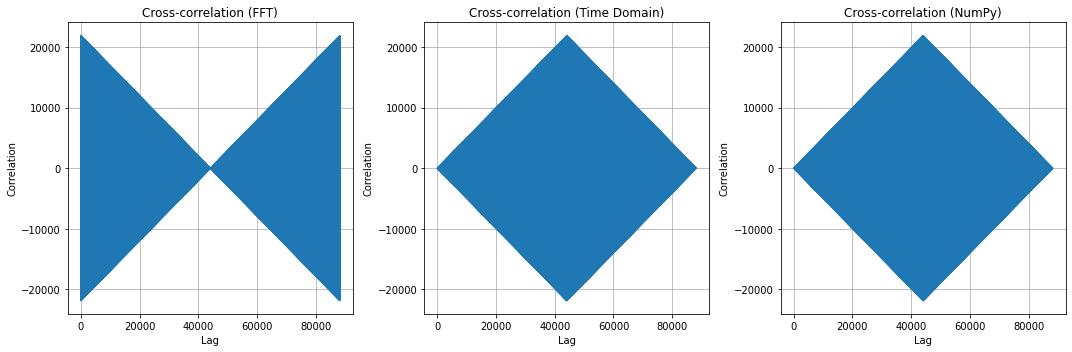

In [38]:
def normalize(signal):
    signal_min = np.min(signal)
    signal_max = np.max(signal)
    return 2 * (signal - signal_min) / (signal_max - signal_min) - 1

def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def fft_correlation(x, y):
    N = len(x) + len(y) - 1
    X = np.fft.fft(x, N)
    Y = np.fft.fft(y, N)
    Y_conj = np.conj(Y)
    product = X * Y_conj
    correlation = np.fft.ifft(product).real
    return correlation

def time_domain_correlation(x, y):
    correlation = np.zeros(len(x) + len(y) - 1)
    for lag in range(-len(y) + 1, len(x)):
        if lag < 0:
            correlation[lag + len(y) - 1] = np.sum(x[:lag] * y[-lag:])
        else:
            correlation[lag + len(y) - 1] = np.sum(x[lag:] * y[:len(y) - lag])
    return correlation

def numpy_correlation(x, y):
    return np.correlate(x, y, mode='full')



# サンプルレート
RATE = 44100
DURATION = 1.0  # 秒

t = np.linspace(0, DURATION, int(RATE * DURATION), endpoint=False)
frequency = 440  # Hz
signal = np.sin(2 * np.pi * frequency * t)

# 信号の正規化
signal_normalized = normalize(signal)

signal_smoothed = moving_average(signal_normalized, window_size=5)

# クロス相関の計算
correlation_fft = fft_correlation(signal_smoothed, signal_smoothed)
correlation_time = time_domain_correlation(signal_smoothed, signal_smoothed)
correlation_numpy = numpy_correlation(signal_smoothed, signal_smoothed)

delay_fft = np.argmax(correlation_fft) - (len(signal_smoothed) - 1)
delay_time = np.argmax(correlation_time) - (len(signal_smoothed) - 1)
delay_numpy = np.argmax(correlation_numpy) - (len(signal_smoothed) - 1)

print(f"Calculated delay (FFT): {delay_fft}")
print(f"Calculated delay (Time Domain): {delay_time}")
print(f"Calculated delay (NumPy): {delay_numpy}")

# 結果のプロット
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(correlation_fft,)
plt.title('Cross-correlation (FFT)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(correlation_time)
plt.title('Cross-correlation (Time Domain)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(correlation_numpy)
plt.title('Cross-correlation (NumPy)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid()

plt.tight_layout()
plt.show()